In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import cross_val_score, cross_val_predict
from xgboost import XGBClassifier
import numpy as np
import itertools
import seaborn
from sklearn.metrics import roc_auc_score
from experiments.libs import loaders
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from xgboost import XGBModel

from lightgbm import LGBMClassifier

import mne
from scipy.io import loadmat

from itertools import zip_longest
from copy import deepcopy

from matplotlib import pyplot as plt
%matplotlib inline

/home/hoaphumanoid/anaconda3/envs/strata/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
filepath = '/fileshare/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
srate = 240 # Hz
# Filtered 0.1 - 60Hz

In [3]:
def create_event_frame(flash_series, stimtype_series):
    diff_seq = flash_series.diff()
    # First event will be missing so fill with 1
    return pd.DataFrame({'flash_onset':diff_seq.fillna(1), 
                         'stim_type': stimtype_series})

In [4]:
def epoch_generator(eeg_data, event_df, duration=0.8, srate=240):
    """ Yields epoch as well as classification label
    """
    offset = int(np.round(duration * srate))
    for idx in event_df[event_df['flash_onset']==1].index:
        data = eeg_data[idx:idx+offset, :] - eeg_data[idx, :] # Removing offset
        yield data, event_df['stim_type'].at[idx]

In [5]:
def dataset_epoch_generator(filename, srate=240):
    dataset_dict = loadmat(filename)
    num_runs = dataset_dict['Flashing'].shape[0]
    
    for run in range(num_runs):
        eeg_array = dataset_dict['Signal'][run,:,:]
        flash_series = pd.Series(dataset_dict['Flashing'][run, :])
        stimtype_series = pd.Series(dataset_dict['StimulusType'][run, :])
        event_df = create_event_frame(flash_series, stimtype_series)
        # Transforming from time by channel to channel by time
        eeg_array = mne.filter.filter_data(eeg_array.astype(np.float64).T, srate, None, 18, verbose=False).T
        for epoch in epoch_generator(eeg_array, event_df, duration=0.8, srate=srate):
            yield epoch

In [6]:
egen = dataset_epoch_generator(filepath, srate=srate)
data_list = list(egen)

In [7]:
len(data_list)

15300

In [8]:
X = np.array([d[0][::6].ravel() for d in data_list])

In [9]:
y = np.array([d[1] for d in data_list])

In [10]:
X.shape

(15300, 2048)

In [11]:
y.shape

(15300,)

In [42]:
pipeline_steps = [('scale', StandardScaler())]
continuous_pipeline = Pipeline(steps=pipeline_steps)

In [43]:
featurisers = [('continuous', continuous_pipeline)]

In [92]:
xgb_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', XGBClassifier(max_depth=2, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                gamma=0.1,
                                                                subsample=1))]) 

In [93]:
lgbm_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', LGBMClassifier(num_leaves=2**2,
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                subsample=1))]) 

In [94]:
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ123456789_'
stim_code_translation_dict = dict((l, (i%6+1, int(np.floor(i/6)+7)) ) for i, l in enumerate(letters))

In [95]:
def event_frame_from(stim_code, target_letter, stim_code_translation_dict):
    diff_seq = stim_code.diff()
    diff_seq = diff_seq.fillna(stim_code)
    
    target_codes = stim_code_translation_dict[target_letter]
    target_index = diff_seq[diff_seq.isin(target_codes)].index
    stimtype_series = pd.Series(0, index=stim_code.index)
    stimtype_series[target_index]=1
    diff_seq = (diff_seq/diff_seq.abs()).fillna(0)
    
    return pd.DataFrame({'flash_onset':diff_seq, 
                         'stim_type': stimtype_series})

In [96]:
test_filename = '/fileshare/BCI_Comp_III_Wads_2004/Subject_A_Test.mat'
labels_filename = '/fileshare/BCI_Comp_III_Wads_2004/true_labels_a.txt'

In [97]:
def read_labels(filename):
    return open(filename).readline().strip()

In [98]:
def test_dataset_epoch_generator(data_filename, labels_filename, stim_code_translation_dict, srate=240):
    dataset_dict = loadmat(data_filename)
    labels = read_labels(labels_filename)
    
    for run, target in enumerate(labels):
        eeg_array = dataset_dict['Signal'][run,:,:]
        stimcode_series = pd.Series(dataset_dict['StimulusCode'][run, :])
        
        event_df = event_frame_from(stimcode_series, target, stim_code_translation_dict)
        
        # Transforming from time by channel to channel by time
        eeg_array = mne.filter.filter_data(eeg_array.astype(np.float64).T, srate, None, 18, verbose=False).T
        for epoch in epoch_generator(eeg_array, event_df, duration=0.8, srate=srate):
            yield epoch

In [99]:
data_gen = test_dataset_epoch_generator(test_filename, labels_filename, stim_code_translation_dict)

In [100]:
data_list = list(data_gen)

In [101]:
X_test = np.array([d[0][::6].ravel() for d in data_list])

In [102]:
y_test = np.array([d[1] for d in data_list])

In [103]:
X_test.shape

(18000, 2048)

In [104]:
%%time
xgb_clf_pipeline.fit(X, y)

CPU times: user 2min 23s, sys: 11.3 s, total: 2min 35s
Wall time: 8.63 s


Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None)), ('clf', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=2, seed=0, silent=True, subsample=1))])

In [105]:
y_pred = xgb_clf_pipeline.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:, 1])

0.66727786666666666

In [106]:
%%time
lgbm_clf_pipeline.fit(X, y)

CPU times: user 24.6 s, sys: 3.88 s, total: 28.5 s
Wall time: 3.41 s


Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None)), ('clf', LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, drop_rate=0.1,
        is_un...   subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False))])

In [107]:
y_pred = lgbm_clf_pipeline.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:, 1])

0.66764502222222222

In [62]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

In [65]:
a=grouper(X, 15*12)

In [74]:
np.array(next(a)).shape

(180, 2048)

In [112]:
xgb_clf_pipeline.fit(X,y)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None)), ('clf', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=2, seed=0, silent=True, subsample=1))])

In [113]:
def run_train_retrain_comparison(model, X, y, X_test, y_test):
    retrain_model = deepcopy(model)
    historical_X = [X]
    historical_y = [y]
    train_auc=[]
    retrain_auc=[]
    for X_chunk, y_chunk in  zip(grouper(X_test, 15*12), grouper(y_test, 15*12)):
        X_chunk_array = np.array(X_chunk)
        y_chunk_array = np.array(y_chunk)

        y_pred = model.predict_proba(X_chunk_array)
        train_auc.append(roc_auc_score(y_chunk_array, y_pred[:, 1]))
        print('Train ', train_auc[-1])

        y_pred = retrain_model.predict_proba(X_chunk_array)
        retrain_auc.append(roc_auc_score(y_chunk_array, y_pred[:, 1]))
        print('Retrain ', retrain_auc[-1])

        historical_X.append(X_chunk_array)
        historical_y.append(y_chunk_array)

        new_train_X  = np.concatenate(historical_X)
        retrain_model.fit(new_train_X, np.concatenate(historical_y))
        
    return pd.DataFrame({
        'train_auc':train_auc,
        'retrain_auc':retrain_auc
    })

In [ ]:
%time df = run_train_retrain_comparison(xgb_clf_pipeline, X, y, X_test, y_test)

Train  0.733777777778
Retrain  0.733777777778
Train  0.670444444444
Retrain  0.668666666667
Train  0.648888888889
Retrain  0.644
Train  0.624444444444
Retrain  0.629555555556
Train  0.701777777778
Retrain  0.702666666667
Train  0.656222222222
Retrain  0.624666666667
Train  0.578
Retrain  0.596888888889
Train  0.678
Retrain  0.681555555556
Train  0.719777777778
Retrain  0.673555555556
Train  0.649333333333
Retrain  0.646222222222
Train  0.582444444444
Retrain  0.587777777778
Train  0.636888888889
Retrain  0.620888888889
Train  0.492666666667
Retrain  0.508888888889
Train  0.673777777778
Retrain  0.650444444444
Train  0.658222222222
Retrain  0.697777777778
Train  0.711333333333
Retrain  0.698
Train  0.606222222222
Retrain  0.621777777778
Train  0.764444444444
Retrain  0.780444444444
Train  0.719333333333
Retrain  0.705333333333
Train  0.753111111111
Retrain  0.713555555556
Train  0.718666666667
Retrain  0.739333333333
Train  0.661111111111
Retrain  0.728222222222
Train  0.675555555556
Re

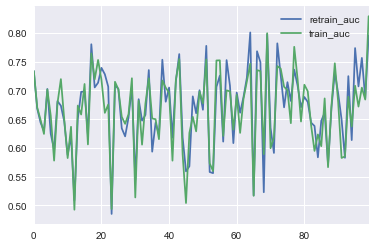

In [ ]:
df.plot()

In [ ]:
df.mean()

retrain_auc    0.670507
train_auc      0.666556
dtype: float64

/home/hoaphumanoid/anaconda3/envs/strata/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  if __name__ == '__main__':


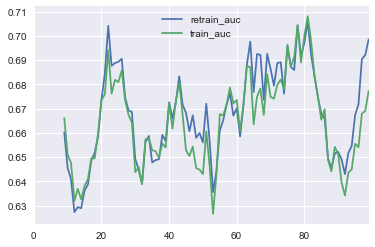

In [ ]:
pd.rolling_mean(df, 10).plot()

In [ ]:
%time df = run_train_retrain_comparison(lgbm_clf_pipeline, X, y, X_test, y_test)

Train  0.752444444444
Retrain  0.752444444444
Train  0.651333333333
Retrain  0.654888888889
Train  0.624666666667
Retrain  0.646888888889
Train  0.654444444444
Retrain  0.618888888889
Train  0.663111111111
Retrain  0.682666666667
Train  0.665111111111
Retrain  0.633111111111
Train  0.596888888889
Retrain  0.597333333333
Train  0.659777777778
Retrain  0.679333333333
Train  0.715111111111
Retrain  0.664888888889
Train  0.682444444444
Retrain  0.659555555556
Train  0.557777777778
Retrain  0.602
Train  0.652444444444
Retrain  0.647333333333
Train  0.506888888889
Retrain  0.510666666667
Train  0.685555555556
Retrain  0.670222222222
Train  0.672444444444
Retrain  0.701777777778
Train  0.721111111111
Retrain  0.711333333333
Train  0.602444444444
Retrain  0.644888888889
Train  0.781111111111
Retrain  0.763555555556
Train  0.714888888889
Retrain  0.717333333333
Train  0.758666666667
Retrain  0.737333333333
Train  0.728666666667
Retrain  0.726222222222
Train  0.638444444444
Retrain  0.7064444444

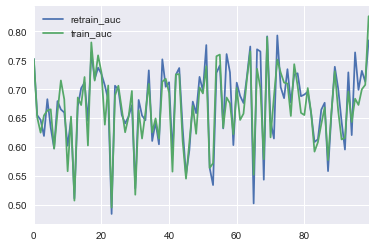

In [119]:
df.plot()

In [120]:
df.mean()

retrain_auc    0.673169
train_auc      0.666938
dtype: float64

/home/hoaphumanoid/anaconda3/envs/strata/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  if __name__ == '__main__':


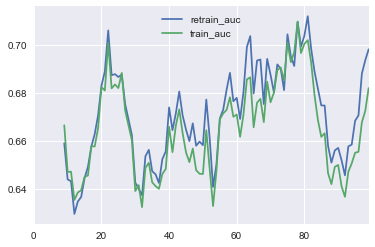

In [121]:
pd.rolling_mean(df, 10).plot()